In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, \
    RobustScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [2]:
np.random.seed(42)
set_config(display='diagram')

plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style="whitegrid")

In [3]:
train_df = trainDf = pd.read_csv("data/train.csv")
test_df = testDf = pd.read_csv("data/test.csv")
full_df = fullDf = pd.concat([trainDf, testDf], sort=True).reset_index(drop=True)

## Data Preparation

In [4]:
num_features = [f for f in full_df.columns if full_df.dtypes[f] != 'object']
num_features.remove('Id')
num_features.remove('SalePrice')

cat_features = [f for f in full_df.columns if full_df.dtypes[f] == 'object']

In [5]:
for feature in (
    'PoolQC', 
    'FireplaceQu', 
    'Alley', 
    'Fence', 
    'MiscFeature', 
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'BsmtFinType1', 
    'BsmtFinType2',
    'GarageType', 
    'GarageFinish', 
    'GarageQual', 
    'GarageCond',
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'BsmtFinType1', 
    'BsmtFinType2',
    'MasVnrType',
    'MSSubClass',
):
    train_df[feature] = train_df[feature].fillna('None')
    test_df[feature] = test_df[feature].fillna('None')
    full_df[feature] = full_df[feature].fillna('None')

for feature in (
    'BsmtFinSF1', 
    'BsmtFinSF2', 
    'BsmtUnfSF',
    'TotalBsmtSF', 
    'BsmtFullBath', 
    'BsmtHalfBath',
    'MasVnrArea',
    'GarageCars',
    'GarageArea',
    'GarageYrBlt',
):
    train_df[feature] = train_df[feature].fillna(0)
    test_df[feature] = test_df[feature].fillna(0)
    full_df[feature] = full_df[feature].fillna(0)

for feature in (
    'Electrical', 
    'KitchenQual', 
    'Exterior1st',
    'Exterior2nd', 
    'SaleType',
    'MSZoning',
    'Utilities',
):
    train_df[feature] = train_df[feature].fillna(train_df[feature].mode()[0])
    test_df[feature] = test_df[feature].fillna(test_df[feature].mode()[0])
    full_df[feature] = full_df[feature].fillna(test_df[feature].mode()[0])

train_df['Functional'] = train_df['Functional'].fillna('Typical')
test_df['Functional'] = test_df['Functional'].fillna('Typical')
full_df['Functional'] = full_df['Functional'].fillna('Typical')

In [6]:
for dataframe in [train_df, test_df]:
    dataframe['Exterior1st'].replace(['Brk Cmn', 'CmentBd', 'Wd Shng'], ['BrkComm', 'CemntBd', 'Wd Sdng'], inplace=True)
    dataframe['Exterior2nd'].replace(['Brk Cmn', 'CmentBd', 'Wd Shng'], ['BrkComm', 'CemntBd', 'Wd Sdng'], inplace=True)

In [7]:
ordinal_feature_mapping = {
    'ExterQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}, 
    'ExterCond': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'BsmtQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'KitchenQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'PoolQC': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'Fence': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Alley': {'None': 0, 'Pave': 1, 'Grvl': 2},
    'Street': {'Pave': 0, 'Grvl': 1},
}

non_ordinal_cat_features = list(set(cat_features) - set(ordinal_feature_mapping.keys()))

for cat_feature in non_ordinal_cat_features:
    train_df[cat_feature + 'Enc'] = LabelEncoder().fit_transform(train_df[cat_feature])
    test_df[cat_feature + 'Enc'] = LabelEncoder().fit_transform(test_df[cat_feature])

for ordinal_feature, feature_mapping in ordinal_feature_mapping.items():
    train_df[ordinal_feature + 'Enc'] = train_df[ordinal_feature].map(feature_mapping)
    test_df[ordinal_feature + 'Enc'] = test_df[ordinal_feature].map(feature_mapping)

## Feature Engineering

In [8]:
for dataframe in [train_df, test_df]:
    dataframe['Has2ndFloor'] = dataframe['2ndFlrSF'].apply(lambda x: int(x > 0))
    dataframe['HasBsmnt'] = dataframe['TotalBsmtSF'].apply(lambda x: int(x > 0))
    dataframe['HasGarage'] = dataframe['GarageArea'].apply(lambda x: int(x > 0))
    dataframe['HasPool'] = dataframe['PoolArea'].apply(lambda x: int(x > 0))
    dataframe['HasFence'] = dataframe['Fence'].apply(lambda x: int(x != 'None'))
    dataframe['HasFireplace'] = dataframe['Fireplaces'].apply(lambda x: int(x > 0))
    dataframe['HasMasVnr'] = dataframe['MasVnrType'].apply(lambda x: int(x != 'None'))

    dataframe['HouseAge'] = dataframe['YrSold'].astype('int') - dataframe['YearBuilt'].astype('int')
    dataframe['HouseAgeSinRemod'] = dataframe['YrSold'].astype('int') - dataframe['YearRemodAdd'].astype('int')

In [9]:
# Remove outliers
train_df.drop(
    train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 700000)].index
);

In [10]:
# 'HeatingQC',
# 'Electrical',
# 'Exterior1st',
# 'Exterior2nd',
# 'GarageQual',
# 'KitchenAbvGr',
# 'KitchenQual',
# 'Foundation',
# 'HouseStyle',
# 'MSZoning',
#'YearBuilt',

baseline_features = [
    '1stFlrSF',
    '2ndFlrSF',
    'BsmtFinSF1', 
    'BsmtFinSF2',
    'BsmtFinType1Enc',
    'BsmtFinType2Enc',
    'BsmtUnfSF',
    'OverallQual',
    'GarageType',
    'GarageCondEnc',
    'GarageCars',
    'OverallCond', 
    'Neighborhood',
    'MSSubClass', 
    'LotShape',
    'LotConfig',
    'LandSlope',
    'BsmtCondEnc',
    'BsmtQualEnc',
    'SaleCondition',
    'CentralAirEnc',
    'Condition1',
    'Condition2',
    'FullBath',
    'GarageFinishEnc',
    'KitchenQualEnc',
    #'HeatingQCEnc',
]

X = train_df[baseline_features]
Y = train_df['SalePrice']

In [ ]:
subclassCategories = [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190]
basementFinishCategories = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
electricalCategories = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']

exteriorCategories = ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']

conditionCategories = train_df['Condition1'].unique()
neighborhoodCategories = full_df['Neighborhood'].unique()
saleCondCategories = full_df['SaleCondition'].unique()
garageTypeCategories = full_df['GarageType'].unique()
lotConfigCategories = full_df['LotConfig'].unique()
lotShapeCategories = full_df['LotShape'].unique()
landSlopeCategories = full_df['LandSlope'].unique()

## Modeling

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.3, random_state=42)

In [13]:
# Build feature transformer

logTransformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

featureTransformer = ColumnTransformer([
        ('basement_area_log', logTransformer, ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']),
        ('neighborhood_onehot', OneHotEncoder(categories=[neighborhoodCategories]), ['Neighborhood']),
        ('subclass_onehot', OneHotEncoder(categories=[subclassCategories]), ['MSSubClass']),
        ('lotconfig_onehot', OneHotEncoder(categories=[lotConfigCategories]), ['LotConfig']),
        ('lot_shape_onehot', OneHotEncoder(categories=[lotShapeCategories]), ['LotShape']),
        ('land_slope_onehot', OneHotEncoder(categories=[landSlopeCategories]), ['LandSlope']),
        ('sale_condtion_onehot', OneHotEncoder(categories=[saleCondCategories]), ['SaleCondition']),
        ('garage_type_onehot', OneHotEncoder(categories=[garageTypeCategories]), ['GarageType']),
        ('condition_onehot', OneHotEncoder(categories=[conditionCategories, conditionCategories]), ['Condition1', 'Condition2']),
        
        # ('yr_built_encode', OrdinalEncoder(categories=[year_built_categories]), ['YearBuilt']),
        # ('zoning_onehot', OneHotEncoder(), ['MSZoning']),
        # ('electrical_onehot', OneHotEncoder(categories=[electricalCategories]), ['Electrical']),
        # ('exterior_onehot', OneHotEncoder(categories=[exteriorCategories, exteriorCategories]), ['Exterior1st', 'Exterior2nd']),
        #('heating_qc_onehot', OneHotEncoder(), ['HeatingQC']),
        # ('kitchen_qc_onehot', OneHotEncoder(categories=[kitchenQCCategories]), ['KitchenQual']),
    ],
    remainder='passthrough'
)

In [14]:
random_forest_pipeline = Pipeline([
    ('preprocessing', featureTransformer),
    ('random_forest', RandomForestRegressor(
        bootstrap=True,
        random_state=42,
        max_depth=15,
        min_samples_leaf=5,
        min_samples_split=5,
        n_estimators=1200,
    )),
])

random_forest_pipeline.fit(X_train, y_train)

y_train_predicted = random_forest_pipeline.predict(X_train)
y_validation_predicted_rf = random_forest_pipeline.predict(X_validation)

print('[Train] MSE: %.2f' % mean_squared_error(y_train, y_train_predicted))
print('[Train] MAE: %.2f' % mean_absolute_error(y_train, y_train_predicted))
print('[Train] R^2: %.2f' % r2_score(y_train, y_train_predicted))
print('[Test] MSE: %.2f' % mean_squared_error(y_validation, y_validation_predicted_rf))
print('[Test] MAE: %.2f' % mean_absolute_error(y_validation, y_validation_predicted_rf))
print('[Test] R^2: %.2f' % r2_score(y_validation, y_validation_predicted_rf))

scores = cross_validate(random_forest_pipeline, X, Y, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], n_jobs=-1, verbose=0)

print('[CV] MSE: %.2f' % (-1 * scores['test_neg_mean_squared_error'].mean()))
print('[CV] MAE: %.2f' % (-1 * scores['test_neg_mean_absolute_error'].mean()))
print('[CV] R^2: %.2f' % scores['test_r2'].mean())

[Train] MSE: 556872045.97
[Train] MAE: 13427.21
[Train] R^2: 0.91
[Test] MSE: 1053084421.84
[Test] MAE: 18735.75
[Test] R^2: 0.86
[CV] MSE: 1046066132.94
[CV] MAE: 19214.29
[CV] R^2: 0.84


In [15]:
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

parameters = {
    'random_forest__bootstrap': [True],
    'random_forest__max_depth': [8],
    'random_forest__max_features': ['sqrt', 'auto', 'log2'],
    'random_forest__min_samples_leaf': [1, 2, 5],
    'random_forest__min_samples_split': [1, 2, 5],
    'random_forest__n_estimators': [1000, 1500, 2000]
}

#paramSearch = GridSearchCV(
#    estimator=random_forest_pipeline,
#    scoring='neg_mean_squared_error',
#    param_grid=parameters, 
#    cv=5,
#    n_jobs=-1, 
#    verbose=2
#)

#paramSearch.fit(X, Y)
#paramSearch.best_params_

In [16]:
#paramSearch.best_score_

In [17]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X_train, y_train, cv, train_sizes=np.linspace(0.1, 1, 10)):
    plt.style.use('seaborn-darkgrid')
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, 
        scoring='neg_mean_squared_error',
        cv=cv, 
        n_jobs=-1, 
        train_sizes=train_sizes,
        shuffle=True,
        random_state=42
        )
    train_mean_scores = np.mean(train_scores, axis=1)
    test_mean_scores = np.mean(test_scores, axis=1)

    plt.title('Learning curve')
    plt.plot(train_sizes, train_mean_scores, 'y', label='Train Learning curve')
    plt.plot(train_sizes, test_mean_scores, 'b', label='Test Learning curve')
    plt.legend()

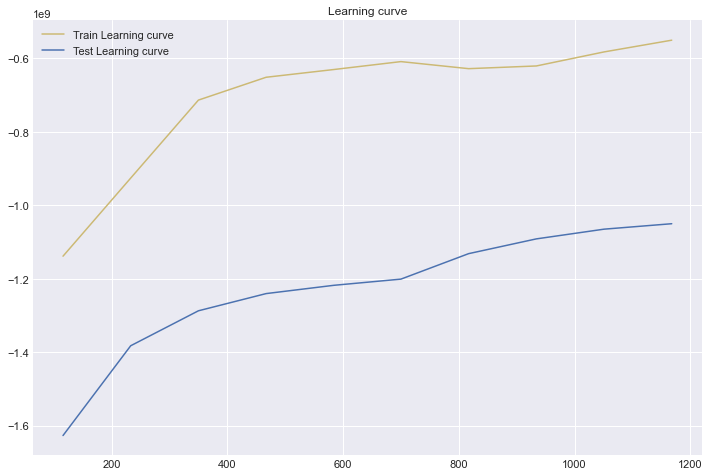

In [18]:
plot_learning_curve(random_forest_pipeline, X, Y, cv=5subclassCategories = [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190]
basementFinishCategories = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
electricalCategories = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']

exteriorCategories = ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']

conditionCategories = train_df['Condition1'].unique()
neighborhoodCategories = full_df['Neighborhood'].unique()
saleCondCategories = full_df['SaleCondition'].unique()
garageTypeCategories = full_df['GarageType'].unique()
lotConfigCategories = full_df['LotConfig'].unique()
lotShapeCategories = full_df['LotShape'].unique()
landSlopeCategories = full_df['LandSlope'].unique())

In [19]:
x_test = test_df[baseline_features]
y_test_predicted = random_forest_pipeline.predict(x_test)

submission_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': y_test_predicted,
})

submission_df.to_csv('./data/submission_random_forest.csv', index=False)